# Embeddings and RAG

In this notebook we will learn what an embedding and how it can be used in retrieval, later to augment LLM generation.

In [1]:
!pip install -q sentence_transformers transformers hf_transfer torch plotly scipy tqdm matplotlib pandas

import os

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


An embeding is a vector representation of a piece of information. The information can be a word (token), a paragraph, an image, etc.  
The vector resides in a high-dimensional space, named the ***embedding space*** or ***latent space***.

<br>

The model that generates the embedding is called an encoder. You can find many example of encoders such as:
- the embedding layer of an LLM, which takes a token and converts it into a vector the model can understand.
- a model that can take many text tokens and convert them into a vector encoding the meaning of the text.
- a model that can take an image and convert it into a vector represntation of the image.

---

We will be using [`stella`](https://huggingface.co/dunzhang/stella_en_1.5B_v5) as a test model.
Stella is an encoder model capable of generating an embedding from up to 512 tokens.

We will be using the first layer of `stella` to visualize and undetstand 1 token embeddings, and the entire model to understand multi-token embeddings.

`sentence_transformers` will be the library used to load the model and generate embeddings.


In [2]:
from sentence_transformers import SentenceTransformer
import torch

with torch.no_grad():
    model = SentenceTransformer(
        "dunzhang/stella_en_1.5B_v5",
        trust_remote_code=True,
        device="cuda",
        model_kwargs={"torch_dtype": torch.float16},
    )


## Let's understand embeddings

For simplicity, we will be using pure 1 token embeddings. They are mostly a 1-to-1 mapping between a work and the representation of that word in the embedding space.  

We will be using the first layer of the model, and working with the input embedding space.

In [3]:
token_to_internal_embedding_weights = next(model[0].named_parameters())[1]

In [4]:
words = ["bird", "woman", "man", "person"]
tokens = [model.tokenizer.vocab[x] for x in words]
for word, token in zip(words, tokens):
    print(f"{word} token:", token)

embeddings = token_to_internal_embedding_weights[[token for token in tokens]]
for word, embedding in zip(words, embeddings):
    print(f"{word} embedding:", embedding)

bird token: 22592
woman token: 22028
man token: 1515
person token: 8987
bird embedding: tensor([ 0.0307,  0.0019, -0.0015,  ..., -0.0216,  0.0342,  0.0062],
       device='cuda:0', dtype=torch.float16, grad_fn=<UnbindBackward0>)
woman embedding: tensor([-0.0081,  0.0173, -0.0048,  ...,  0.0002, -0.0101,  0.0237],
       device='cuda:0', dtype=torch.float16, grad_fn=<UnbindBackward0>)
man embedding: tensor([-0.0140, -0.0220, -0.0115,  ..., -0.0002,  0.0038,  0.0136],
       device='cuda:0', dtype=torch.float16, grad_fn=<UnbindBackward0>)
person embedding: tensor([ 0.0046,  0.0035,  0.0173,  ..., -0.0100,  0.0056, -0.0030],
       device='cuda:0', dtype=torch.float16, grad_fn=<UnbindBackward0>)


What can we do with this embedding vector?

The vectors depresent a direction from the point of origin, which means that if we have 2 vectors, we can compare their distance using a few metrics:
- the cosine distance / cosine similarity
- the euclidean distance
- the manhattan distance

---

The most common metric is the cosine similarity, which is the angle between the two vectors inside the latent space.  

The cosine similarity is calculated by:
1. Normalizing both vectors (dividing by their magnitude/length)
2. Taking the dot product of the normalized vectors
 
This gives us a value between -1 and 1:
- 1 means the vectors point in exactly the same direction (very similar)
- 0 means the vectors are perpendicular (unrelated)
- -1 means the vectors point in opposite directions (very dissimilar)

Let's encode a few words and compare their distance.

In [5]:
def cosine_similarity(v1, v2):
    # Normalize vectors
    v1_normalized = v1 / torch.norm(v1)
    v2_normalized = v2 / torch.norm(v2)

    # Compute cosine similarity (dot product of normalized vectors)
    similarity = torch.dot(v1_normalized, v2_normalized)

    return similarity.item()

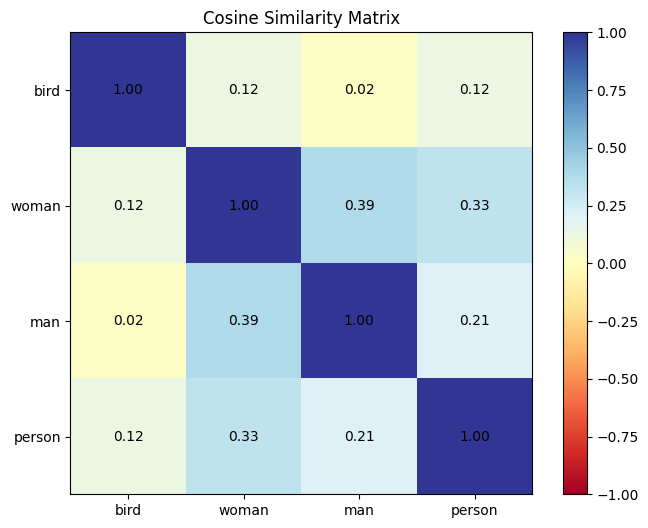

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate similarity matrix
similarity_matrix = torch.zeros((len(words), len(words)))

for i in range(len(words)):
    for j in range(len(words)):
        similarity_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])

# Create heatmap
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, cmap="RdYlBu", vmin=-1, vmax=1)

# Add labels
plt.xticks(range(len(words)), words)
plt.yticks(range(len(words)), words)

# Add colorbar
plt.colorbar()

# Add values in cells
for i in range(len(words)):
    for j in range(len(words)):
        plt.text(j, i, f"{similarity_matrix[i,j]:.2f}", ha="center", va="center")

plt.title("Cosine Similarity Matrix")
plt.show()


## Embedding vectors arithmetic

Since we're working with vectors, we can do vector arithmetic to navigate the latent space.



Firstly, let's reduce the dimensionality of the embedding space to 2D, so we can visualize it.

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=128)
input_embeddings_2d = pca.fit_transform(
    token_to_internal_embedding_weights.detach().cpu().numpy()
)

Pick a few words and plot them in the 2D space.

In [42]:
man_embedding = input_embeddings_2d[model.tokenizer.vocab["man"]]
king_embedding = input_embeddings_2d[model.tokenizer.vocab["king"]]

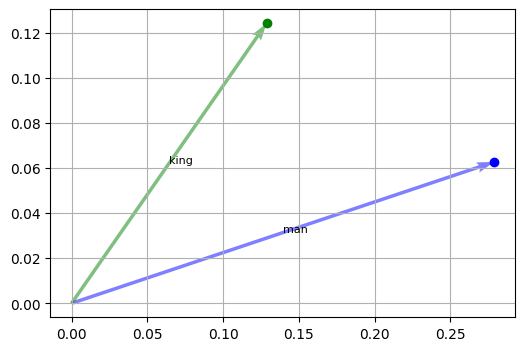

In [67]:
import matplotlib.pyplot as plt


def visualize_vectors(embeddings, labels, colors):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)

    for i, ((x0, y0, x1, y1), label, color) in enumerate(
        zip(embeddings, labels, colors)
    ):
        # Draw arrow from origin to point in 2D
        ax.quiver(
            x0,
            y0,
            x1,
            y1,
            color=color,
            angles="xy",
            scale_units="xy",
            scale=1,
            alpha=0.5,
        )
        # Add scatter point and label
        ax.scatter(x0 + x1, y0 + y1, c=color, label=label)
        ax.text(x0 + x1 / 2, y0 + y1 / 2, label, size=8)
    plt.grid(True)
    plt.show()


visualize_vectors(
    [np.pad(man_embedding, (2, 0)), np.pad(king_embedding, (2, 0))],
    ["man", "king"],
    ["blue", "green"],
)

Now, let's visualize the direction of royalty.

We will subtract the man embedding from the king embedding to get the direction of the royalty concept.

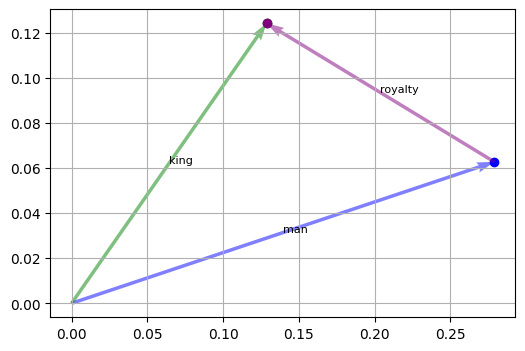

In [68]:
royalty_direction = king_embedding - man_embedding

visualize_vectors(
    [
        np.pad(man_embedding, (2, 0)), np.pad(king_embedding, (2, 0)), np.concatenate((man_embedding, royalty_direction))
    ],
    ["man", "king", "royalty"],
    ["blue", "green", "purple"],
)


Now let's add royalty to the `woman` embedding.

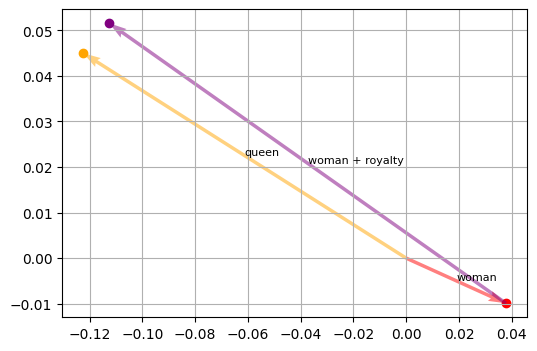

In [69]:
woman_embedding = input_embeddings_2d[model.tokenizer.vocab["woman"]]
queen_embedding = input_embeddings_2d[model.tokenizer.vocab["queen"]]

woman_plus_royalty = woman_embedding + royalty_direction

visualize_vectors(
    [
        np.pad(woman_embedding, (2, 0)),
        np.pad(queen_embedding, (2, 0)),
        np.concatenate((woman_embedding, royalty_direction))
    ],
    ["woman", "queen", "woman + royalty"],
    ["red", "orange", "purple"],
)

And to view all the vectors in the same plot, we can do the following:

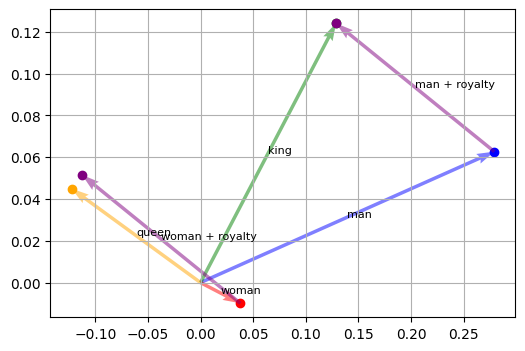

In [70]:
visualize_vectors(
    [
        np.pad(man_embedding, (2, 0)),
        np.pad(woman_embedding, (2, 0)),
        np.pad(king_embedding, (2, 0)),
        np.pad(queen_embedding, (2, 0)),
        np.concatenate((man_embedding, royalty_direction)),
        np.concatenate((woman_embedding, royalty_direction)),
    ],
    ["man", "woman", "king", "queen", "man + royalty", "woman + royalty"],
    ["blue", "red", "green", "orange", "purple", "purple"],
)

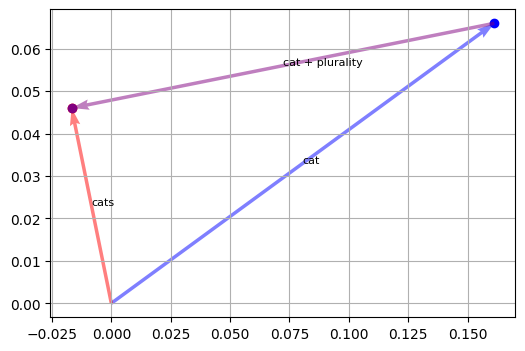

In [76]:
cat_embedding = input_embeddings_2d[model.tokenizer.vocab["cat"]]
cats_embedding = input_embeddings_2d[model.tokenizer.vocab["cats"]]

plurality_direction = cats_embedding - cat_embedding

visualize_vectors(
    [
        np.pad(cat_embedding, (2, 0)),
        np.pad(cats_embedding, (2, 0)),
        np.concatenate((cat_embedding, plurality_direction)),
    ],
    ["cat", "cats", "cat + plurality"],
    ["blue", "red", "purple"],
)


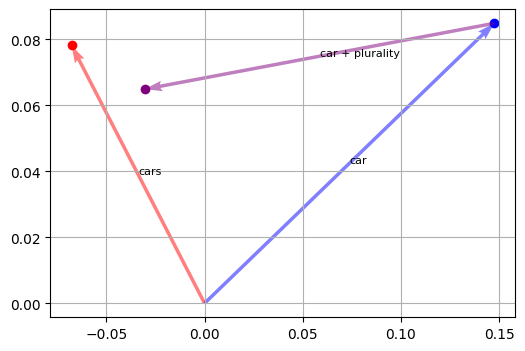

In [81]:
car_embedding = input_embeddings_2d[model.tokenizer.vocab["car"]]
cars_embedding = input_embeddings_2d[model.tokenizer.vocab["cars"]]

car_plus_plurality = car_embedding + plurality_direction

visualize_vectors(
    [
        np.pad(car_embedding, (2, 0)),
        np.pad(cars_embedding, (2, 0)),
        np.concatenate((car_embedding, plurality_direction)),
    ],
    ["car", "cars", "car + plurality"],
    ["blue", "red", "purple"],
)

## Embedding more than 1 token

Let's have a look at the results of encoding a few sentences with the model.

Previously we have played with toy examples of embeddings generated by the first layer of the model, taking a token mapping it to the input embedding space.

The different between the previouse approach and this one is that we will now be encoding an entire sequence of tokens, each token having it's own vector flowing through the model's network, until the final layer, where they are all combined into a single vector.  

---

| Embedding a single token | Embedding a sequence of tokens |
|-------------------------|-------------------------------|
| <img src="./.images/embedding-input-layer.png" width="500" valign="top"> | <img src="./.images/embedding-model.png" width="500" valign="top"> |

---

**Important Notes:** 
- The latent space of a layer (e.g. the first layer) is not the same as the latent space of the model. Each layer generates a different latent space encoding different information.
- The latent space of a model is not the same as the latent space of another model. Results from different encoders (even if having the same dimension) cannot be compared.


In [106]:
paragraphs = [
    # why the sky is blue
    "The sky appears blue due to a phenomenon called Rayleigh scattering. "
    "When sunlight travels through the Earth's atmosphere, it collides with gas molecules. "
    "These molecules scatter the light in all directions, but they scatter shorter wavelengths (blue light) more strongly than longer wavelengths (red light). "
    "This scattered blue light reaches our eyes from all directions in the sky, making it appear blue.",
    
    # health benefits of green tea
    "Green tea offers numerous health benefits due to its high concentration of antioxidants and beneficial compounds. "
    "Regular consumption has been linked to improved brain function, fat loss, protection against cancer, and reduced risk of heart disease. "
    "The tea contains bioactive compounds like polyphenols that can reduce inflammation and help prevent cell damage. "
    "It also contains caffeine and L-theanine, which can improve mood and cognitive performance.",
    
    # how an electric engine works
    "An electric engine, or electric motor, converts electrical energy into mechanical energy through electromagnetic interaction. "
    "It consists of a stator (stationary part) and a rotor (rotating part) that work together using magnetic fields created by electrical current. "
    "When electricity flows through wire coils in the motor, it creates magnetic fields that cause the rotor to spin. "
    "This mechanical rotation can then power various devices, from small appliances to large electric vehicles.",

    # how a combustion engine works
    "A combustion engine converts chemical energy from fuel into mechanical energy through controlled explosions. "
    "The engine uses pistons inside cylinders that move up and down through four main strokes: intake, compression, combustion, and exhaust. "
    "During combustion, fuel mixed with air is ignited by spark plugs, creating explosive force that drives the pistons. "
    "This reciprocating motion is converted to rotary motion by the crankshaft to power vehicles and other machines."
]

paragraph_labels = [
    "Sky",
    "Green Tea",
    "Electric Engine",
    "Combustion Engine"
]

# Encode each paragraph
encoded_paragraphs = model.encode(paragraphs)


Using the cosine similarity metric, let's see how similar are the paragraphs with each other.

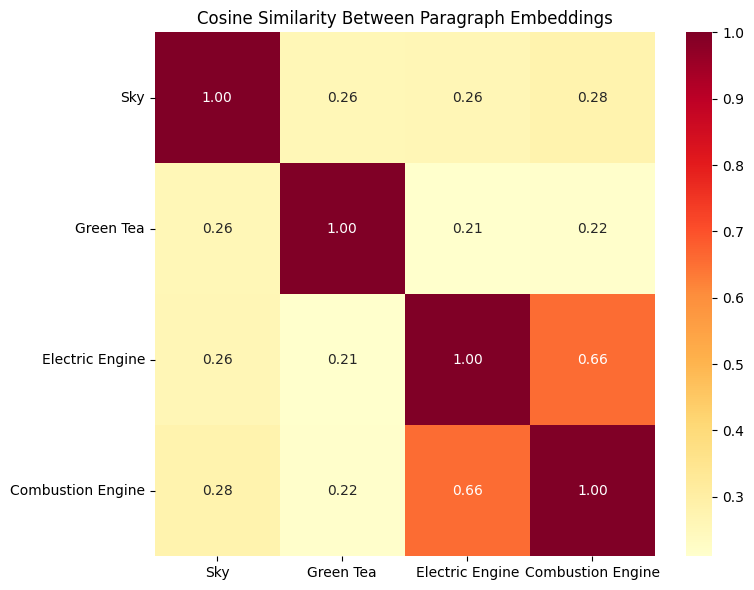

In [107]:
# Calculate cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(encoded_paragraphs)

# Create heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, 
            annot=True, 
            cmap='YlOrRd',
            xticklabels=paragraph_labels,
            yticklabels=paragraph_labels,
            fmt='.2f')
plt.title('Cosine Similarity Between Paragraph Embeddings')
plt.tight_layout()
plt.show()


As you can see, the paragraphs taking about engines have a higher similarity score with each other then the other paragraphs which are cloner to the score of being unrelated.

## Generating embeddings to find similar documents

Some models, like `stella`, can generate embeddings for short questions, that have a high similarity score with documents that tend to answer the question.

This model supports to such queries:
- s2p_query: sequence to paragraph query.  
  This is an instruction that will generate an embedding from a question which is very close to answering documents.  
  `"Instruct: Given a web search query, retrieve relevant passages that answer the query.\nQuery: {text}"`  
  
- s2s_query: sequence to sequence query.  
  This is an instruction that will generate an embedding looking for semantically similar documents.  
  `"Instruct: Retrieve semantically similar text.\nQuery: {text}"`  

Let's see how this works.



In [116]:
queries = [
    "why is the sky blue?",
    "what's up with green tea?",
    "Why is green tea good for you?",
    "how does an engine work?",
    "how does an electric engine work?",
    "how does a combustion engine work?",
]
query_embeddings = model.encode(queries, prompt_name='s2p_query')

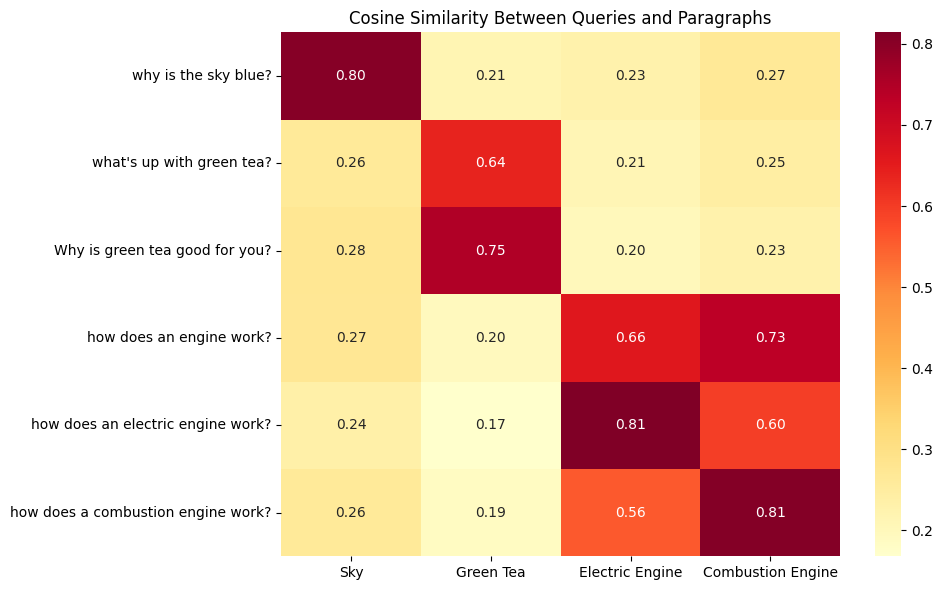

In [117]:
# Calculate cosine similarity between queries and paragraphs
similarity_matrix = cosine_similarity(query_embeddings, encoded_paragraphs)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(similarity_matrix,
            annot=True,
            cmap='YlOrRd',
            xticklabels=paragraph_labels,
            yticklabels=queries,
            fmt='.2f')
plt.title('Cosine Similarity Between Queries and Paragraphs')
plt.tight_layout()
plt.show()


| Query | Observation |
|-------|-------------|
| "why is the sky blue?" | Very similar to the sky paragraph, unrelated to other paragraphs |
| "what's up with green tea?" | Very similar to green tea paragraph |
| "Why is green tea good for you?" | Very similar to green tea paragraph, with higher similarity than general query |
| "how does an engine work?" | Closely matches both engine paragraphs, shows higher similarity to combustion engines reflecting common terminology |
| "how does an electric engine work?" | Matches both engine paragraphs, but shows stronger similarity to the electric engine paragraph |
| "how does a combustion engine work?" | Matches both engine paragraphs, but shows stronger similarity to the combustion engine paragraph |
